## Getting Started
This notebook provides a baseline model using PU learning techniques to tackle this challenge.

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import problem

X_df, y = problem.get_train_data()
train_df, test_df, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)
train_df['label'] = y_train
test_df['label'] = y_test
# Display dataset information
print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)

# Sample of train dataset
train_df.head()

Train dataset shape: (44730, 3)
Test dataset shape: (11183, 3)


,text,type,label
31309,“my son holds a lot of resentment towards me a...,unlabeled,0
30919,i gotta friend who is known for talkin shit al...,unlabeled,0
37807,"If that's what a voter believe, that explained...",unlabeled,0
21499,Snoop Dogg didn't start saying -izzle but he w...,human,1
47441,These alternatives to popular apps can help re...,unlabeled,0


Unique types in train dataset:
['unlabeled' 'human' 'llm']
Type distribution in train dataset:
type
unlabeled    26433
human        14314
llm           3983
Name: count, dtype: int64


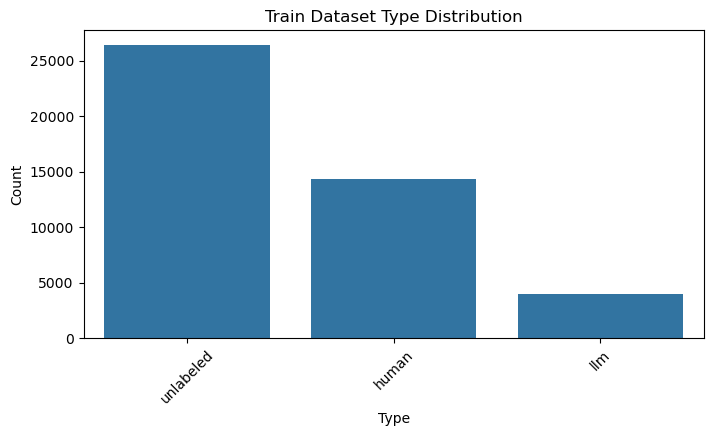

In [15]:
# Unique types in the training dataset
unique_types = train_df['type'].unique()
print("Unique types in train dataset:")
print(unique_types)
print("Type distribution in train dataset:")
print(train_df['type'].value_counts())

# Plot type distribution for training dataset
plt.figure(figsize=(8, 4))
sns.countplot(x='type', data=train_df, order=train_df['type'].value_counts().index)
plt.title("Train Dataset Type Distribution")
plt.xlabel("Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


Let's have a look at an interesting column in our  dataset : 'type'. This column is referring to the labelling method employed, it takes three values : 

* 'unlabeled': Which means the text has not been labeled
* 'human': Which indicates that the text has been annotated by a human labeler
* 'llm': Which indicates the annotation by a LLM (Notably Llama 3.2 2B)

Note that the label for unlabeled samples is by default zero. The PU learning task will require you to adjust this label as close as possible to its true value.


## Exploring the Labels,
Before training the model, let's inspect the unique values and their counts in the `label` column for both the training and test datasets"
   

Unique labels in train dataset:
[0 1]
Label distribution in train dataset:
label
0    27365
1    17365
Name: count, dtype: int64


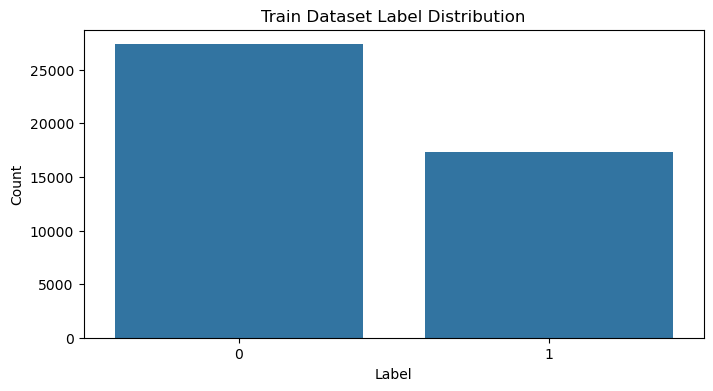

In [16]:
# Unique labels and counts in the training dataset
unique_train = train_df['label'].unique()
print("Unique labels in train dataset:")
print(unique_train)
print("Label distribution in train dataset:")
print(train_df['label'].value_counts())

# Plot label distribution for training dataset
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=train_df, order=train_df['label'].value_counts().index)
plt.title("Train Dataset Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

Unique labels in test dataset:
[0 1]
Label distribution in test dataset:
label
0    6868
1    4315
Name: count, dtype: int64


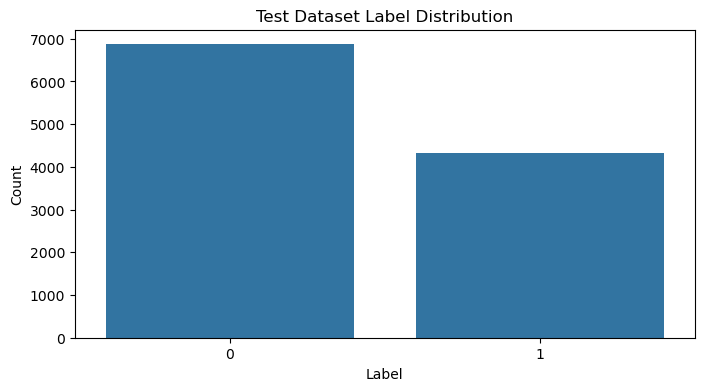

In [17]:
# Unique labels and counts in the test dataset
unique_test = test_df['label'].unique()
print("Unique labels in test dataset:")
print(unique_test)
print("Label distribution in test dataset:")
print(test_df['label'].value_counts())

# Plot label distribution for test dataset
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=test_df, order=test_df['label'].value_counts().index)
plt.title("Test Dataset Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


## Baseline Model
We will implement a simple **Positive-Unlabeled (PU) learning** model using logistic regression. Since we lack explicit negative labels, we will use a two-step approach:
1. Train a naive model using only positive and unlabeled data.
2. Use heuristics or additional methods to infer probable negative instances.


In [18]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Convert text data into numerical features
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['text'].astype(str))
X_test = vectorizer.transform(test_df['text'].astype(str))

# For training data, compare labels as strings
y_train = train_df['label']

# For test data, convert labels to binary (assuming 1 is positive and 0 is negative)
y_test = test_df['label']

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict probabilities on the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions using a threshold
threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)

# Evaluate the model using F1-score
f1 = f1_score(y_test, y_pred, average='binary')
print("F1-score:", f1)


F1-score: 0.7233883989566513


Note that this score is artificially inflated as the labels for 'unlabeled' test is incorrectly set to 0.

Combining this baseline in a sklearn pipeline and evaluating the score with cross-validation gives the following :

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer

def get_tf_idf_features(X_df):
    tf_idf = TfidfVectorizer(max_features=100)
    X_df_features = tf_idf.fit_transform(X_df['text'].astype(str))
    return X_df_features.toarray() # Convert to dense format 

cols = ['text']

transformer = make_column_transformer(
    (FunctionTransformer(lambda X_df: get_tf_idf_features(X_df)), cols),
)

pipeline = make_pipeline(
    transformer,
    LogisticRegression()
)

def get_estimator():
    return pipeline

In [20]:
import problem
from sklearn.model_selection import cross_val_score

X_df, y = problem.get_train_data()

scores = cross_val_score(get_estimator(), X_df, y, cv=2, scoring='f1')
print(scores)

[0.54706341 0.31926659]


## PU-Learning Approach

PU (Positive-Unlabeled) learning is a specialized machine learning approach used when we only have positive (P) examples and unlabeled (U) data, but no explicit negative examples. The goal of PU learning is to create a model that can distinguish between true positives and true negatives from the unlabeled data.

We will now implement a PU learning model using the **ElkanotoPuClassifier**, a specialized classifier designed for this task.

PU learning is based on the assumption that:
1. **Positive Data (P)**: These are explicitly labeled examples that we know belong to the positive class (1).
2. **Unlabeled Data (U)**: These are data points that are neither labeled as positive nor negative. However, to our case, they can contain both true negatives (0) and unknown labels. The challenge lies in determining which of these examples are actually negative, as they have not been explicitly labeled.

### Key Ideas to take into account

#### **ElkanotoPuClassifier**:  
This is a wrapper for standard classifiers that applies PU learning. Specifically, it adapts the classifier's training process to account for the unlabeled data. The `ElkanotoPuClassifier` is an implementation of the **nnPU (non-negative PU learning)** algorithm, which improves upon traditional PU learning techniques by more accurately estimating the number of true negatives.

#### **How nnPU Works**

1. **Positive Data (P)**: These are data points that have been explicitly labeled as belonging to the positive class. In the context of our problem, these would be comments labeled as positive or relevant (1).

2. **Unlabeled Data (U)**: These are data points that are unlabeled but may contain both positive and negative examples. Unlabeled data is typically treated as negative in traditional PU learning, but this assumption can be biased.

3. **Hold-out Set**: To improve the model's performance, nnPU uses a hold-out set. This set is a small portion (typically 10%) of the unlabeled data that is kept separate during training. The purpose of this set is to estimate the proportion of true negatives within the unlabeled data.

#### **Risk Estimation**

In traditional PU learning, all unlabeled data is assumed to be negative, which introduces bias in the model. nnPU, on the other hand, uses the hold-out set to estimate the true negative proportion within the unlabeled set. This estimation is critical as it helps the model to avoid overfitting to the assumption that all unlabeled data is negative.

#### **Optimization in nnPU**

The nnPU algorithm optimizes the model using a risk function that ensures the model does not overfit by treating all unlabeled data as negative. This step helps to find an accurate decision boundary that distinguishes between true positives and true negatives. By adjusting the loss function to account for the uncertainty in the unlabeled data, nnPU improves the generalization of the model.

In [21]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from pulearn import ElkanotoPuClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Load datasets
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=10000, stop_words="english")

# Convert text to TF-IDF vectors
X_train = vectorizer.fit_transform(train_df["text"].astype(str)).toarray()
X_test = vectorizer.transform(test_df["text"].astype(str)).toarray()

# Define labels for PU-learning
# Positive: Explicitly labeled as 1 and from "human" or "llm"
# Unlabeled: label == 0 and type is "unlabeled"
# True Negatives: label == 0 and type is NOT "unlabeled" (these should be excluded)
y_train = np.where(
    (train_df["label"] == 1) & (train_df["type"].isin(["human", "llm"])), 
    1,  # Positive
    np.where(train_df["type"] == "unlabeled", 0, -1)  # Unlabeled (0) or explicit negative (-1)
)

# Filter out explicit negatives (-1) from PU-learning
mask = y_train != -1
X_train_filtered = X_train[mask]
y_train_filtered = y_train[mask]

# Train PU-learning model using nnPU
pu_model = ElkanotoPuClassifier(LogisticRegression(), hold_out_ratio=0.1)
pu_model.fit(X_train_filtered, y_train_filtered)

# Predict probabilities
y_pred_proba = pu_model.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions using a threshold
threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)

# Evaluate performance
f1 = f1_score(test_df["label"].values, y_pred, average="binary")
print("F1-score:", f1)

F1-score: 0.6483245149911817



## Next Steps
Participants are encouraged to:
- Experiment with different **PU learning techniques** such as **weighted loss functions** or **semi-supervised learning**.
- Use **self-training** or **EM algorithms** to improve pseudo-labeling.
- Incorporate **pre-trained embeddings (e.g., BERT, RoBERTa)** for feature extraction.

Good luck with the challenge!
